In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib

In [7]:
pip list

Package                 Version
----------------------- -----------
asttokens               3.0.1
colorama                0.4.6
comm                    0.2.3
contourpy               1.3.3
cycler                  0.12.1
debugpy                 1.8.20
decorator               5.2.1
executing               2.2.1
fonttools               4.61.1
ipykernel               7.2.0
ipython                 9.10.0
ipython_pygments_lexers 1.1.1
jedi                    0.19.2
joblib                  1.5.3
jupyter_client          8.8.0
jupyter_core            5.9.1
kiwisolver              1.4.9
matplotlib              3.10.8
matplotlib-inline       0.2.1
nest-asyncio            1.6.0
numpy                   2.4.2
packaging               26.0
pandas                  3.0.0
parso                   0.8.6
pillow                  12.1.1
pip                     25.2
platformdirs            4.5.1
prompt_toolkit          3.0.52
psutil                  7.2.2
pure_eval               0.2.3
py4j                    0.

In [9]:
df = pd.read_csv("./data/dynamic_record_gesture.csv")

print("Shape:", df.shape)
df.head()


Shape: (2361, 13)


,id,gesture_name,timestamp,ax,ay,az,gx,gy,gz,p0,p1,p2,p3
0,1,idle,1066413,0.01,-0.04,0.82,-0.42,0.41,0.16,4095,4095,4095,4095
1,1,idle,1066425,0.02,-0.05,0.82,0.12,0.39,0.06,4095,4095,4095,4095
2,1,idle,1066437,0.03,-0.03,0.81,-0.25,0.17,-0.25,4095,4095,4095,4095
3,1,idle,1066449,0.04,-0.02,0.84,0.15,0.36,0.12,4095,4095,4095,4095
4,1,idle,1066461,0.03,-0.02,0.83,0.25,0.10,-0.25,4095,4095,4095,4095


In [11]:
# Data Cleaning
df = df.dropna()

# Potentiometer ต้องอยู่ 0–4095
for col in ['p0','p1','p2','p3']:
    df = df[(df[col] >= 0) & (df[col] <= 4095)]

In [12]:
#Smoothing

sensor_cols = ['ax','ay','az','gx','gy','gz','p0','p1','p2','p3']

window_smooth = 5

for col in sensor_cols:
    df[col] = df[col].rolling(window=window_smooth, center=True).mean()

df = df.dropna()

In [13]:
#Normalization 

scaler = StandardScaler()
df[sensor_cols] = scaler.fit_transform(df[sensor_cols])

In [16]:
#Slicing window
window_size = 100   # ปรับตาม sampling rate
step_size = 50      # overlap 50%

X = []
y = []

for session_id in df['id'].unique():
    temp = df[df['id'] == session_id]
    
    data = temp[sensor_cols].values
    labels = temp['gesture_name'].values
    
    for i in range(0, len(data) - window_size, step_size):
        window = data[i:i+window_size]
        label = labels[i]
        
        X.append(window)
        y.append(label)

X = np.array(X)
y = np.array(y)

print("Windowed shape:", X.shape)


Windowed shape: (41, 100, 10)


In [17]:
#Feature Extraction

def extract_features(window):
    feats = []
    feats.extend(np.mean(window, axis=0))
    feats.extend(np.std(window, axis=0))
    feats.extend(np.max(window, axis=0))
    feats.extend(np.min(window, axis=0))
    return feats

X_features = np.array([extract_features(w) for w in X])

print("Feature shape:", X_features.shape)

Feature shape: (41, 40)


In [19]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("Classes:", le.classes_)

Classes: ['1' '2' '3' '4' 'idle']


In [20]:
#Train/Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_encoded, test_size=0.2, random_state=42
)

In [21]:
#Train Model (Random Forest)

model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         3

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



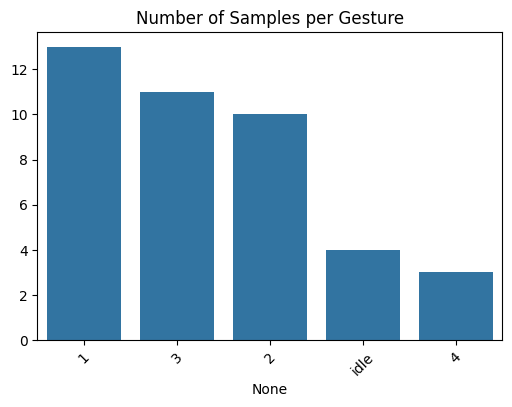

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# นับจำนวน label
label_counts = pd.Series(y).value_counts()

plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Number of Samples per Gesture")
plt.xticks(rotation=45)
plt.show()

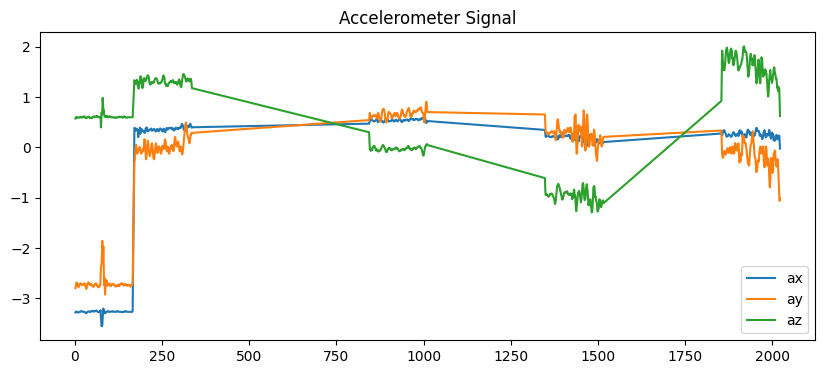

In [25]:
sample_id = df['id'].unique()[0]
temp = df[df['id'] == sample_id]

plt.figure(figsize=(10,4))
plt.plot(temp['ax'], label='ax')
plt.plot(temp['ay'], label='ay')
plt.plot(temp['az'], label='az')
plt.title("Accelerometer Signal")
plt.legend()
plt.show()

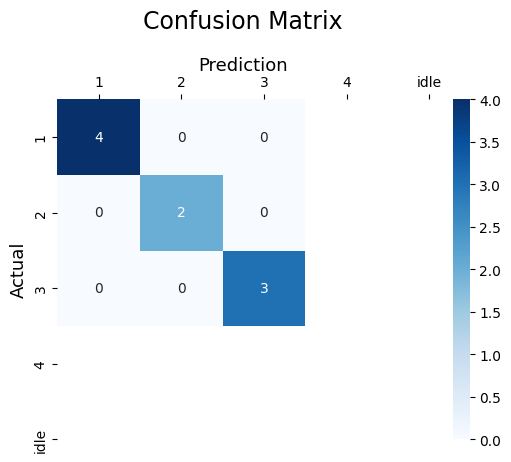

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# สร้าง confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))

sns.heatmap(cm, 
            annot=True,
            fmt='g',
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cmap='Blues')

plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)

# ย้าย label prediction ไปด้านบน
plt.gca().xaxis.set_label_position('top') 
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()

# ปรับ spacing ด้านล่าง
plt.gca().figure.subplots_adjust(bottom=0.2)

plt.show()


In [29]:
train_acc = model.score(X_train, y_train)
test_acc = model.score(X_test, y_test)

print("Train accuracy:", train_acc)
print("Test accuracy:", test_acc)

Train accuracy: 1.0
Test accuracy: 1.0


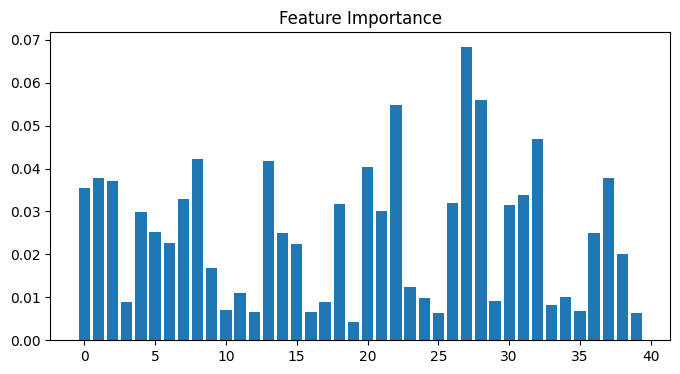

In [30]:
importances = model.feature_importances_

plt.figure(figsize=(8,4))
plt.bar(range(len(importances)), importances)
plt.title("Feature Importance")
plt.show()